This tutorial is generated from a [Jupyter](http://jupyter.org/) notebook that can be found [here](https://github.com/elfi-dev/notebooks). 

## BSL

[Synthetic Likelihood](https://www.nature.com/articles/nature09319) uses a multivariate normal distribution to approximate the likelihood function. Bayesian synthetic likelihood ([BSL](https://www.tandfonline.com/doi/full/10.1080/10618600.2017.1302882)) methods use a Bayesian framework by combining synthetic likelihood with a prior distribution. In comparison to [ABC](https://elfi.readthedocs.io/en/latest/usage/tutorial.html#approximate-bayesian-computation), BSL scales more efficiently with an increase in the dimension of the summary statistic and requires substantially less tuning.

This tutorial demonstrates how to use various BSL methods for LFI in ELFI.

In [1]:
import time

import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

%matplotlib inline
# %precision 2

import elfi

seed = 1
np.random.seed(seed)

We adapt the familiar MA(2) model introduced in the ELFI tutorial. To match examples used in the BSL literature, we take 50 observations and do not perform data summarisation (i.e. take data as the summary statistic).

In [2]:
from elfi.examples import ma2
m = ma2.get_model(n_obs=50, seed_obs=seed)
m.remove_node('S1')
m.remove_node('S2')
m.remove_node('d')

def identity(x):
    return x

elfi.Summary(identity, m['MA2'], name='identity')

Summary(name='identity')

## Standard BSL

BSL in ELFI is split into two stages: specifying the `SyntheticLikelihood` node and the actual sampling. The `SyntheticLikelihood` node is based off the ELFI distance node. The first argument takes in either a string or function argument to specify what BSL method to use. For a string argument, the available options are (note capitalisation not important):
- "BSL" or "sBSL": standard BSL
- "uBSL": unbiased BSL
- "semiBSL": semi-parametric BSL
- "rBSL" or "misspecbsl": robust BSL
<br/>  


A function argument can also be passed in, where the function returns an estimate for the log SL.
<br/>
The inference model is now defined, and we can perform standard BSL.

In [3]:
elfi.SyntheticLikelihood("bsl", m['identity'], name="SL")
elfi.draw(m)

AttributeError: module 'elfi' has no attribute 'SyntheticLikelihood'

Once the synthetic likelihood node is specified, we can sample the approximate posterior distribution using the BSL sampler. This takes the same arguments as other sampler classes implemented in ELFI. One detail however is that `batch_size` refers to the number of simulations used for a single SL estimate, not entire sweeps of the ELFI graph.

In [4]:
batch_size = 500  # number simulations at each MCMC iteration
true_params = np.array([0.6, 0.2])  # can be dictionary or array-like

# create bsl sampler object
bsl_sampler = elfi.BSL(
                m['SL'],  # target node of inference
                batch_size=batch_size,  
                seed=4)


Before calling the `sample` function, some pre-sampling functions can be called. The `plot_covariance_matrix` function visualises the covariance of the summary statistics. This is useful as shrinkage (covered shortly) requires a large number of entries near 0 for the covariance matrix when applying Warton's shrinkage or for the precision matrix (set using argument `precision=True`) for BSLasso.

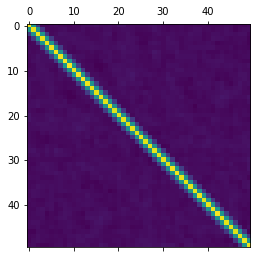

In [5]:
bsl_sampler.plot_covariance_matrix(true_params, batch_size=10000)

As standard BSL requires normality of the summary statistics, it is useful to visualise the summary statistics to assess normality. The `plot_summary_statistics` provides a way to visualise each summary statistic at a theta value of presumed high posterior density. If there is some deviation from normality, semiBSL might be a more appropriate method. If the summaries differ greatly from normality, then all BSL methods might fail. Note, transformations can be applied on summaries (e.g., log transform) to bring them closer to normality.

Progress [==================================================] 100.0% Complete


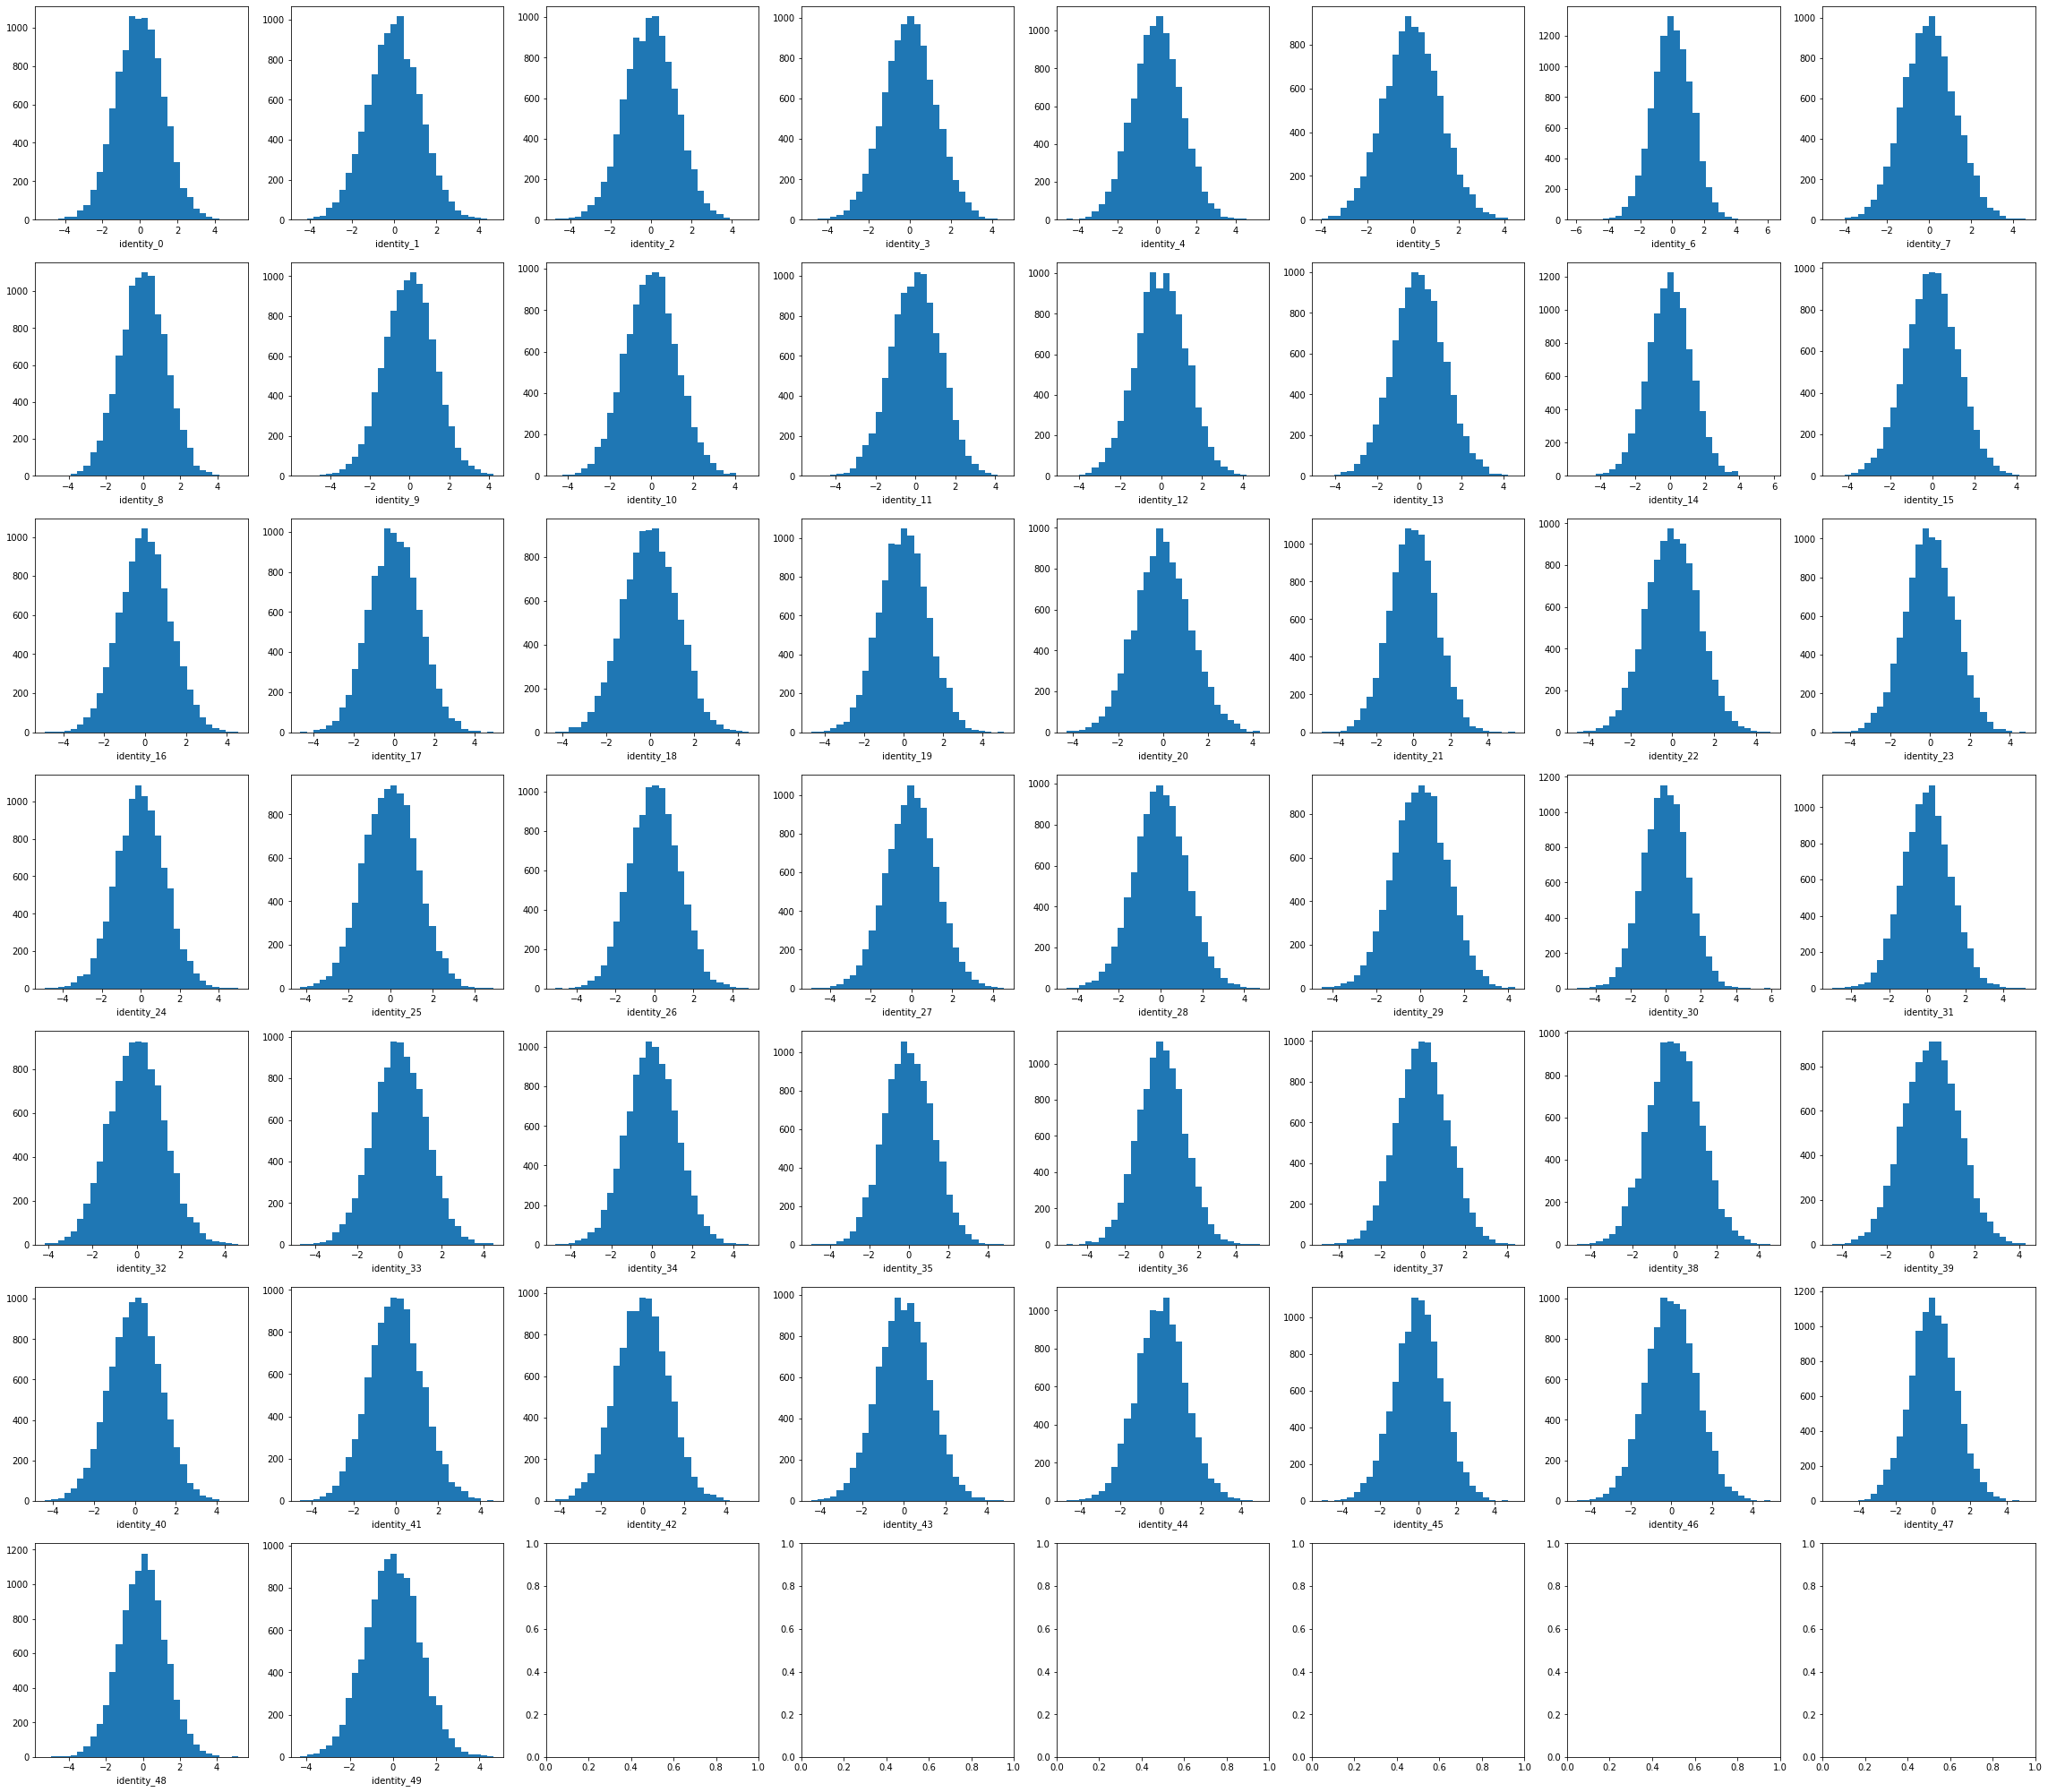

In [6]:
_ = bsl_sampler.plot_summary_statistics(batch_size=10000, theta_point=true_params)

BSL methods are most computationally efficient when the standard deviation of the log SL estimator is between 1 and 2. The `log_SL_stdev` function is useful to estimate this standard deviation. The `batch_size` should be tuned so that the standard deviation is within that range.

In [7]:
M = 100
log_SL = bsl_sampler.log_SL_stdev(true_params, batch_size, M)
print('log_SL:', log_SL)


log_SL: 1.6986826445846084


Samples from the approximate posterior can be acquired using the `BSL` sampler class. This sampler uses MCMC sampling with a Metropolis-Hastings step. A `BslSample` object is returned from the `sample` method.

In [8]:
# sample using sBSL
mcmc_iterations = 2000
est_post_cov =np.array([[0.02, 0.01], [0.01, 0.02]])
burn_in = 0

bsl_res = bsl_sampler.sample(
    mcmc_iterations,  # num samples - required
    params0=true_params, # starting value of MCMC chain - optional
    sigma_proposals=est_post_cov, # proposal cov for random walk - required
    burn_in=burn_in  # burn_in - optional
)

Progress [==================================================] 100.0% Complete


In [9]:
print(bsl_res)
bsl_res.outputs

Method: BSL
Number of samples: 2000
Method: BSL
Number of samples: 2000
Number of simulations: 1000000
MCMC Acceptance Rate: 0.207
Sample means: t1: 0.489, t2: 0.209



{'t1': array([0.6       , 0.6       , 0.58663718, ..., 0.52085048, 0.52085048,
        0.52085048]),
 't2': array([0.2       , 0.2       , 0.28973391, ..., 0.38845595, 0.38845595,
        0.38845595]),
 'SL': array([[-69.70339615],
        [-69.70339615],
        [-69.11416197],
        ...,
        [-69.13600071],
        [-69.13600071],
        [-69.13600071]])}

As MCMC draws correlated samples, it is useful to estimate the effective sample size (ESS) as an estimate of the equivalent number of independent iterations that the MCMC chain represents. This can be estimated using the `compute_ess` function of the `BslSample` class.

In [10]:
bsl_res.compute_ess()

{'t1': 13.94154775129541, 't2': 48.49519210383697}

The `BslSample` object has useful methods to visualise the sample.

array([[<AxesSubplot:ylabel='t1'>],
       [<AxesSubplot:xlabel='Iterations in Chain 0', ylabel='t2'>]],
      dtype=object)

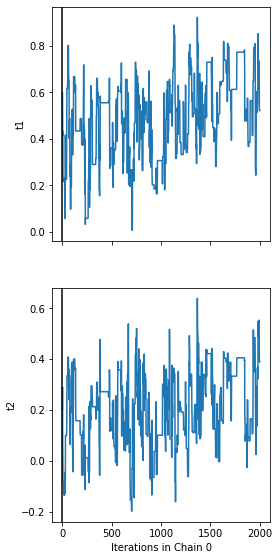

In [11]:
bsl_res.plot_traces()

array([<AxesSubplot:xlabel='t1'>, <AxesSubplot:xlabel='t2'>], dtype=object)

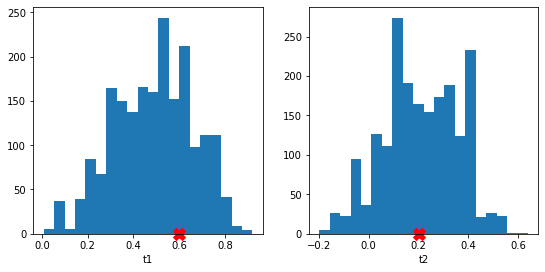

In [12]:
reference_value = {'t1': 0.6, 't2': 0.2}
bsl_res.plot_marginals(reference_value=reference_value)

array([[<AxesSubplot:ylabel='t1'>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='t1', ylabel='t2'>,
        <AxesSubplot:xlabel='t2'>]], dtype=object)

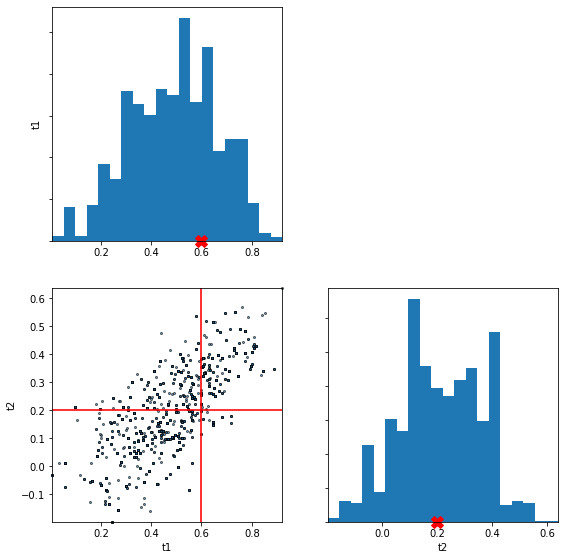

In [13]:
bsl_res.plot_pairs(reference_value=reference_value)

## semiBSL

[SemiBSL](https://www.tandfonline.com/doi/full/10.1080/10618600.2021.1875839) uses a semi-parametric SL estimator that relaxes the normality assumption. This method is recommended when the summary statistics deviate from normality. The only change to use semiBSL is passing "semiBSL" as the first argument of the `SyntheticLikelihood` node. The sampling step is the same as standard BSL

In [14]:
elfi.SyntheticLikelihood("semiBSL", m['identity'], name="semiSL")


SyntheticLikelihood(name='semiSL')

## BSLasso

[BSLasso](https://www.tandfonline.com/doi/full/10.1080/10618600.2018.1537928) uses the graphical lasso (glasso) to accelerate BSL. By applying shrinkage, we can reduce the `batch_size` without detrimentally increasing the standard deviation of the log SL estimator. We highlight here the `select_penalty` function. This method selects the penalty value(s) that gives the closest estimated log-likelihood standard deviation closest to sigma. This is done for each `batch_size` value given (can be an int or array-like).

In [15]:
from elfi.methods.bsl.select_penalty import select_penalty

In [16]:
penalty = select_penalty(m['SL'],
                         batch_size=[150, 300],
                         sigma=1.5,
                         theta={'t1': 0.6, 't2': 0.2},
                         shrinkage="glasso"
                         )


To update with new arguments, we can either create a new `SyntheticLikelihood` node or we can use the `become` function. Note the `SyntheticLikelihood` node takes in two arguments for both shrinkage method and the penalty value.

In [17]:
m['SL'].become(elfi.SyntheticLikelihood("bsl",
                                        m['identity'],
                                        shrinkage="glasso",
                                        penalty=penalty[1]))

## wBSL

Whitening BSL ([wBSL](https://www.tandfonline.com/doi/full/10.1080/10618600.2021.1979012)) decorrelates the summary statistics using a whitening transformation to allow more shrinkage to be applied. The whitening matrix, used for the whitening transformation, is estimated at a parameter point of high posterior density before sampling, using the `estimate_whitening_matrix` function. We then use the `select_penalty` function as outlined for BSLasso. Additionally, the Warton shrinkage estimator is found to give better results of wBSL. It is recommended to always set `shrinkage=warton` when using whitening transformations with BSL. Whitening transformations can also be used with semiBSL ([wsemiBSL](https://arxiv.org/abs/2007.01485)).

In [18]:
from elfi.methods.bsl.estimate_whitening_matrix import \
    estimate_whitening_matrix

In [19]:
true_params = np.array([0.6, 0.2])

elfi.SyntheticLikelihood("bsl", m['identity'], name="wSL")

W = estimate_whitening_matrix(m['wSL'], theta_point=true_params,
                               batch_size=20000)
m['wSL'].become(elfi.SyntheticLikelihood("bsl", m['identity'], whitening=W,
                                        shrinkage="warton"))
batch_size = 80
penalty = select_penalty(m['wSL'],
                         batch_size=batch_size,
                         M=10,
                         sigma=1.5,
                         theta={'t1': 0.6, 't2': 0.2}
                         )
m['wSL'].become(elfi.SyntheticLikelihood("bsl", m['identity'], whitening=W,
                                        shrinkage="warton", penalty=penalty))
wbsl_sampler = elfi.BSL(
            m['wSL'],
            batch_size=batch_size,
            seed=123,
            )

## R-BSL

Robust BSL ([R-BSL](https://www.tandfonline.com/doi/full/10.1080/10618600.2021.1875839)) is able to perform useful parameter inference even if the model is misspecified. A model is said to be "misspecified in the BSL sense" if the model is unable to replicate the observed summary statistics. R-BSL adds free parameters to absorb the impact of model misspecification. The free parameters either adjusts the sample mean (R-BSL-M) or the sample covariance (R-BSL-V). The adjustment argument of the `SyntheticLikelihood` node determines which method is used.

In [20]:
elfi.SyntheticLikelihood("rbsl", m['identity'], adjustment="mean", name="R-SL-M")
elfi.SyntheticLikelihood("rbsl", m['identity'], adjustment="variance", name="R-SL-V")

SyntheticLikelihood(name='R-SL-V')

## Parallelising simulations

A new approach to parallelisation is recommended for BSL methods. The main computational cost from inference with BSL methods is usually from running the simulations. Existing approaches in ELFI parallelise the entire sweep of the graph. This approach differs as we only want to simulate a single node, the `Simulator` node, rather than the whole graph. To parallelise a `Simulator` node, the user can set `parallelise=True` and set the number of processes with the `num_processes` argument. If `num_processes=None` then it defaults to `os.cpu_count()`. Parallelisation is done through the multiprocessing library. There is a trade-off in using this parallelisation approach as the simulations are no longer vectorised.
